In [247]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
import math

import warnings
warnings.filterwarnings("ignore")

Using saas.csv or log data from API usage:

- Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
- Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

Using store item demand:

- Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.
- Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
- Plot the 2018 monthly sales predictions.

In [190]:
df = pd.read_csv("saas.csv")

In [191]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [192]:
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)
df.rename(columns={"Amount":"y", "Month_Invoiced":"ds"},inplace=True)
df = df.set_index("ds")
df = df[["y"]]

In [193]:
df.head()

,y
ds,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0


##### Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [194]:
df = df.y.resample("M").sum()

In [195]:
df.head()

ds
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: y, dtype: float64

In [196]:
def split_data(df, train_prop=.80): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size].reset_index(), df[train_size:len(df)].reset_index()
    return train, test

In [197]:
train, test = split_data(df)

In [198]:
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 48
Training Observations: 38
Testing Observations: 10


##### Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

In [199]:
train = train.set_index("ds")
test = test.set_index("ds")

In [200]:
train.head()

,y
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [201]:
test.head()

,y
ds,
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0
2017-06-30,53405.0
2017-07-31,53680.0


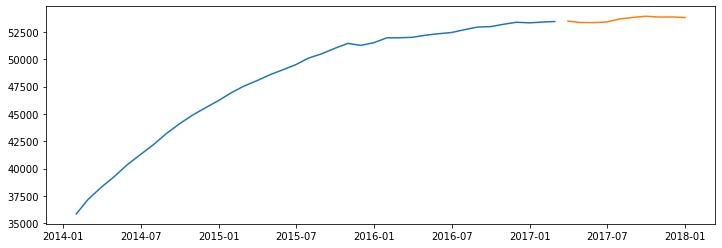

In [202]:
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)
plt.show()

In [203]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [252]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [205]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

##### Simple Average

In [206]:
yhat = pd.DataFrame(test.copy())

In [207]:
yhat["y"] = round(train.y.mean(),1)

In [209]:
yhat.info()
yhat.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2017-03-31 to 2017-12-31
Data columns (total 1 columns):
y    10 non-null float64
dtypes: float64(1)
memory usage: 160.0 bytes


,y
ds,
2017-03-31,48206.2
2017-04-30,48206.2
2017-05-31,48206.2
2017-06-30,48206.2
2017-07-31,48206.2


In [210]:
target_var = ["y"]

In [214]:
evaluate(target)

MSE:  29700147.340000033
RMSE: 5449.784155358819


y -- MSE: 29700147.34 RMSE: 5449.78


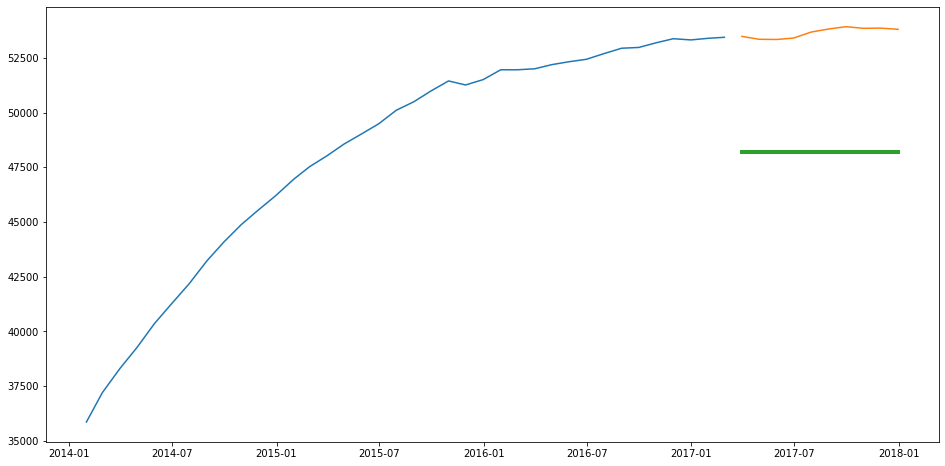

In [213]:
plot_and_eval(target_var)

In [215]:
train.tail(1)

,y
ds,
2017-02-28,53440.0


In [216]:
test.head(1)

,y
ds,
2017-03-31,53480.0


In [253]:
eval_df = append_eval_df("simple_avg","y")
eval_df

,model_type,target_var,metric,value
0,simple_avg,y,mse,1.869372e+06
1,simple_avg,y,rmse,1.367250e+03


##### Moving Average

In [221]:
# periods = 30
yhat['y'] = train.y.rolling(1).mean().iloc[-1]

In [224]:
evaluate(target_var)

MSE:  93587.5
RMSE: 305.9207413693946


y -- MSE: 93587.50 RMSE: 305.92


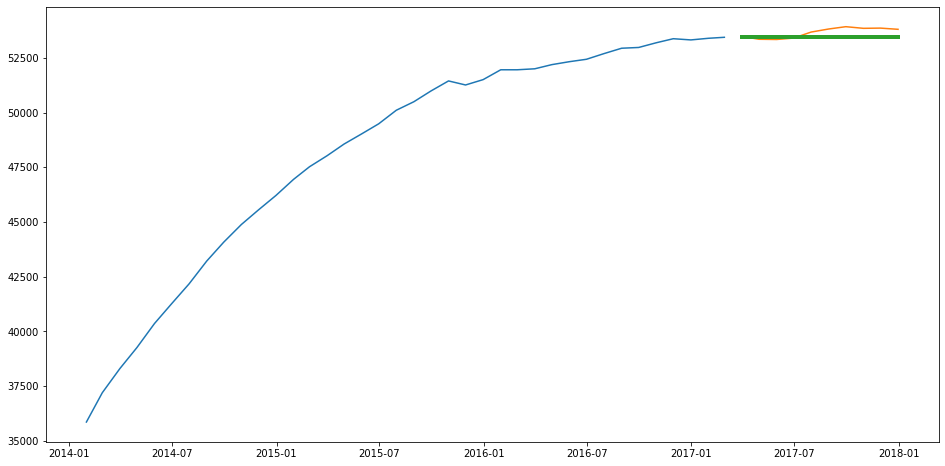

In [225]:
plot_and_eval(target_var)

In [254]:
eval_df = append_eval_df("rolling_avg","y")
eval_df

,model_type,target_var,metric,value
0,simple_avg,y,mse,1.869372e+06
1,simple_avg,y,rmse,1.367250e+03
2,rolling_avg,y,mse,1.869372e+06
3,rolling_avg,y,rmse,1.367250e+03


##### Holt's Linear Trend Model

In [239]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2014-01-31 to 2017-02-28
Data columns (total 1 columns):
y    38 non-null float64
dtypes: float64(1)
memory usage: 608.0 bytes


y 



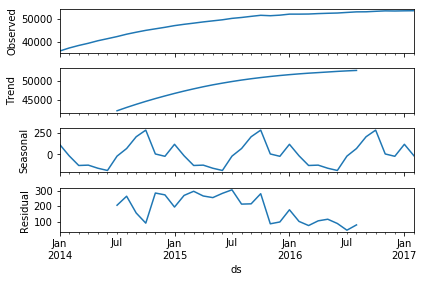

In [245]:
for var in target_var:
    print(var,'\n')
    _ = sm.tsa.seasonal_decompose(train[var]).plot()
    plt.show()

In [250]:
from statsmodels.tsa.api import Holt

model = Holt(train['y']).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
yhat['y'] = pd.DataFrame(model.forecast(test['y'].shape[0]), columns=['y'])

y -- MSE: 1869371.78 RMSE: 1367.25


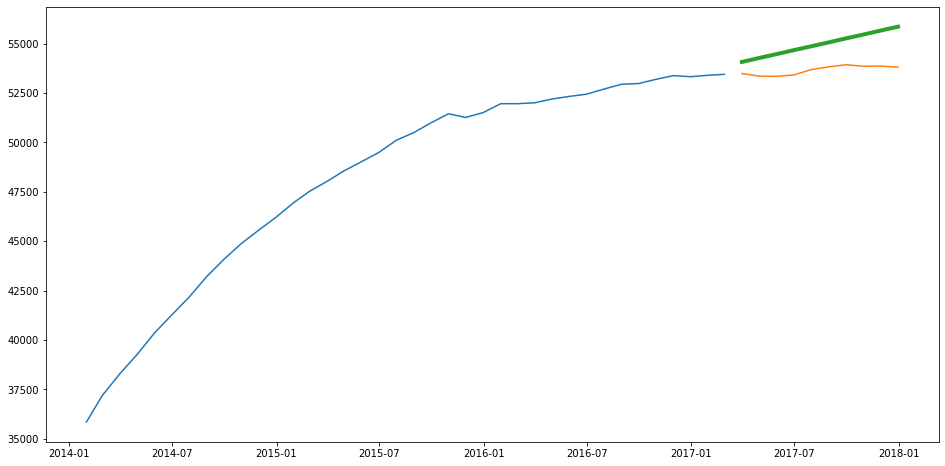

In [251]:
plot_and_eval(target_var, train, test)

In [257]:
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=['y'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,simple_avg,y,mse,1.869372e+06
1,simple_avg,y,rmse,1.367250e+03
2,rolling_avg,y,mse,1.869372e+06
3,rolling_avg,y,rmse,1.367250e+03
4,holts_linear_trend,y,mse,1.869372e+06
5,holts_linear_trend,y,rmse,1.367250e+03


##### Based on previous year/month/etc., this is up to you.

In [258]:
train

,y
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [ ]:
yhat = train['2015-04-20':'2017-02-28'] + train['2013-04-20':'2017-02-28'].diff(365).mean()
# set the date (index) to be represent the date for our predictions
# yhat.index = pd.date_range('2016-04-20', periods=len(yhat))
yhat.tail()

Using store item demand:

Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.
Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
Plot the 2018 monthly sales predictions.